<p><img alt="Colaboratory logo" height="50px" src="http://ingeotec.mx/~mgraffg/ingeotec-bg.png" align="left" hspace="10px" vspace="0px"></p>

<h1>$\mu$TC's Quickstart Guide</h1>

### http://ingeotec.mx

### http://github.com/ingeotec

## Install $\mu$TC

In [ ]:
!pip install microtc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 443.5 kB/s eta 0:00:00


## Reading a dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from microtc.utils import tweet_iterator
D = list(tweet_iterator("/content/BD Aumentada.json"))
Y = [x["klass"] for x in D]

##Text model

In [ ]:
from microtc.textmodel import TextModel
tm = TextModel(token_list=[-1, -2, (2, 1), 4]).fit(D)

In [ ]:
tm["hola mundo"]

[]

In [ ]:
tm.transform("hello world")

array([[0.        , 0.57735027, 0.57735027, 0.        , 0.57735027,
        0.        ]])

## Text Classifier

In [ ]:
from sklearn.svm import LinearSVC
X = tm.transform(D)
model = LinearSVC().fit(X, Y)

In [ ]:
model.predict(tm.transform(["las mujeres no deberian manejar"]))

array(['sexist'], dtype='<U10')

# Dividiendo en train y test set

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(D, Y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'max_iter': [5000, 10000, 15000, 20000, 30000],
        'tol': [1e-4, 1e-3, 1e-2]
}

# Performance LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

P = []
X_svc = np.empty((len(x_train), 1))
for tr, vs in tqdm(kfold.split(X_svc, y_train_encoded), total=5):
  #Conjunto de entrenamiento
  D_tr = [x_train[x] for x in tr]
  Y_tr = [y_train_encoded[x] for x in tr]
  #Conjunto de validación
  D_vs = [x_train[x] for x in vs]
  Y_vs = [y_train_encoded[x] for x in vs]

  #Transformaciones de texto a los conjuntos
  tm_svc = TextModel(token_list=[-1, -2, 3]).fit(D_tr)
  X_tr = tm_svc.transform(D_tr)
  X_vs = tm_svc.transform(D_vs)

  #Entrenamos el modelo
  clf = LinearSVC()
  random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid,n_iter=10, cv=5, scoring='accuracy', verbose=1)
  random_search.fit(X_tr, Y_tr)

  #Entrenamos con los mejores hiperparámetros
  best_model = random_search.best_estimator_
  hy = best_model.predict(X_vs)

  #Calculamos el accuracy score
  acc = accuracy_score(Y_vs, hy, normalize=True)
  P.append(acc)

np.mean(P, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 20%|██        | 1/5 [02:53<11:35, 173.77s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 40%|████      | 2/5 [03:45<05:05, 101.97s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 60%|██████    | 3/5 [04:39<02:39, 79.92s/it] 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 80%|████████  | 4/5 [07:22<01:53, 113.04s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


100%|██████████| 5/5 [08:01<00:00, 96.29s/it]


0.7363802932988788

In [ ]:
y_predSVC = best_model.predict(tm_svc.transform(x_test))

In [ ]:
#Accuracy Score
acc_SVC = accuracy_score(y_test_encoded, y_predSVC, normalize=True)
acc_SVC

0.7548387096774194

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test_encoded, y_predSVC)

0.733274647887324

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test_encoded, y_predSVC)

0.7083333333333334

In [ ]:
from sklearn.model_selection import cross_val_predict
scores_SVC = cross_val_predict(best_model, tm_svc.transform(x_train), y_train_encoded, cv=3,method="decision_function")
pred_scoresSVC = best_model.decision_function(tm_svc.transform(x_test))

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisión")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    # Resaltar un umbral específico (por ejemplo, el umbral medio)
    threshold_highlight = len(thresholds) // 2
    plt.plot(thresholds[threshold_highlight], precisions[threshold_highlight], "bo")
    plt.plot(thresholds[threshold_highlight], recalls[threshold_highlight], "go")

    # Agregar la leyenda, las etiquetas de los ejes y la cuadrícula
    plt.xlabel("Umbrales")
    plt.title("Precisión y Recall vs. Umbrales")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

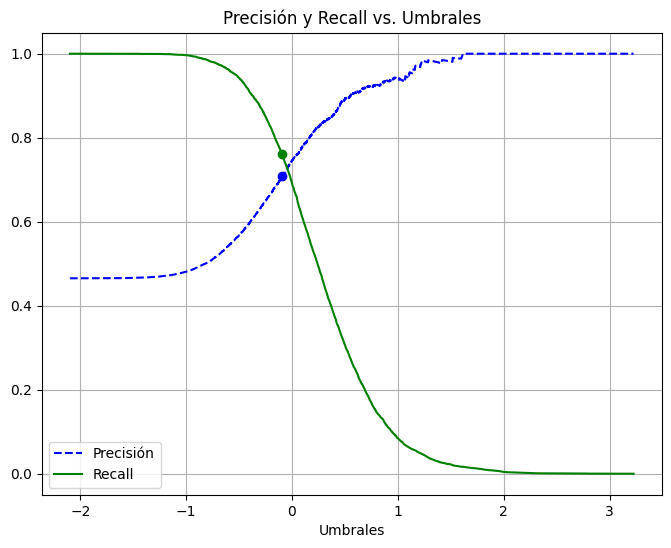

In [ ]:
#Curva precisión y recall vs umbral
precision_SVC, recall_SVC, thresholds_SVC = precision_recall_curve(y_train_encoded, scores_SVC)
plot_precision_recall_vs_threshold(precision_SVC, recall_SVC, thresholds_SVC)

In [ ]:
#Umbral para una precisión de 0.75
threshold_90SVC = thresholds_SVC[np.argmax(precision_SVC >= 0.8)]
threshold_90SVC

0.16412529581723645

In [ ]:
y_pred_90SVC = (pred_scoresSVC >= threshold_90SVC)
accuracy_score(y_test_encoded, y_pred_90SVC, normalize=True)

0.7468690702087286

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal punteada

    # Agregar etiquetas de los ejes y la cuadrícula
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

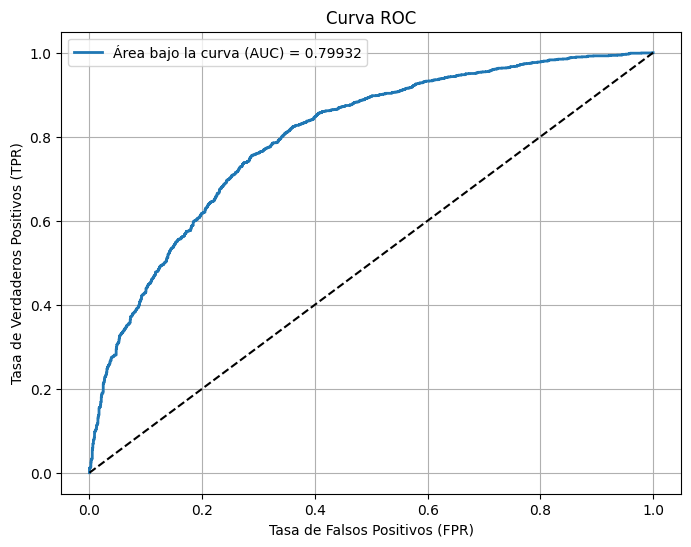

In [ ]:
#Curva ROC
fpr_SVC, tpr_SVC, _ = roc_curve(y_test_encoded, pred_scoresSVC)
roc_auc = roc_auc_score(y_test_encoded, pred_scoresSVC)

# Usar la función plot_roc_curve
plot_roc_curve(fpr_SVC, tpr_SVC, label=f'Área bajo la curva (AUC) = {roc_auc:.5f}')

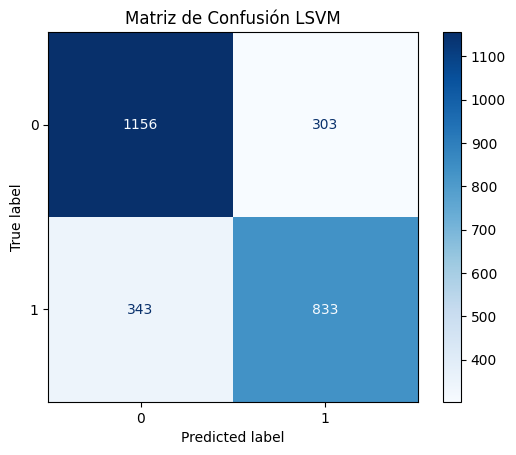

In [ ]:
#Matriz de Confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_encoded, y_predSVC)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.title('Matriz de Confusión LSVM')
plt.show()

# Performance SVC Kernel RBF

In [ ]:
from sklearn.svm import SVC

param_gridRBF = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1],
    'kernel': ['rbf'],
    'max_iter': [5000, 10000, 15000],
    'tol': [1e-3, 1e-4]
}

P_RBF = []
Validation_RBF = []
X_RBF = np.empty((len(x_train), 1))
for tr_RBF, vs_RBF in tqdm(kfold.split(X_RBF, y_train_encoded), total=2):
  #Conjunto de entrenamiento
  D_tr_RBF = [x_train[x] for x in tr_RBF]
  Y_tr_RBF = [y_train_encoded[x] for x in tr_RBF]
  #Conjunto de validación
  D_vs_RBF = [x_train[x] for x in vs_RBF]
  Y_vs_RBF = [y_train_encoded[x] for x in vs_RBF]

  #Transformaciones de texto
  tm_RBF = TextModel(token_list=[-1, -2, 3]).fit(D_tr_RBF)
  X_tr_RBF = tm_RBF.transform(D_tr_RBF)
  X_vs_RBF = tm_RBF.transform(D_vs_RBF)

  #Entrenamos el modelo
  svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
  #random_search_RBF = RandomizedSearchCV(estimator=svm_rbf, param_distributions=param_gridRBF,n_iter=5, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
  svm_rbf.fit(X_tr_RBF, Y_tr_RBF)

  #Entrenamos con los mejores parámetros
  #best_RBF = random_search_RBF.best_estimator_
  hy_RBF = svm_rbf.predict(X_vs_RBF)

  #Calculamos el accuracy score
  acc_RBF = accuracy_score(Y_vs_RBF, hy_RBF, normalize=True)
  P_RBF.append(acc_RBF)

np.mean(P_RBF, axis=0)

100%|██████████| 2/2 [18:31<00:00, 555.79s/it]


0.7416954557533882

In [ ]:
y_predRBF = svm_rbf.predict(tm_RBF.transform(x_test))

In [ ]:
#Accuracy Score
acc_RBF = accuracy_score(y_test_encoded, y_predRBF, normalize=True)
acc_RBF

0.7464895635673624

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test_encoded, y_predRBF)

0.7618556701030927

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test_encoded, y_predRBF)

0.6284013605442177

In [ ]:
from sklearn.model_selection import cross_val_predict
scores_RBF = cross_val_predict(svm_rbf, tm_RBF.transform(x_train), y_train_encoded, cv=2,method="decision_function")
pred_scoresRBF = svm_rbf.decision_function(tm_RBF.transform(x_test))

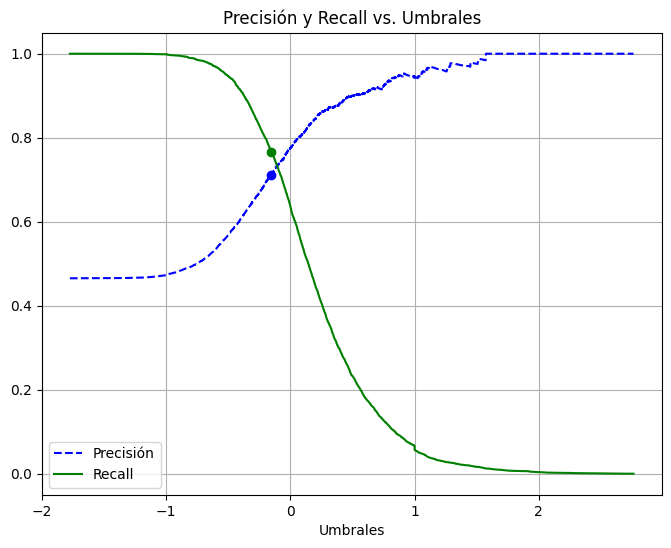

In [ ]:
#Curva precisión y recall vs umbral
precision_RBF, recall_RBF, thresholds_RBF = precision_recall_curve(y_train_encoded, scores_RBF)
plot_precision_recall_vs_threshold(precision_RBF, recall_RBF, thresholds_RBF)

In [ ]:
#Umbral para una precisión de 0.75
threshold_90RBF = thresholds_RBF[np.argmax(precision_RBF >= 0.7)]
threshold_90RBF

-0.18398016641599663

In [ ]:
y_pred_90RBF = (pred_scoresRBF >= threshold_90RBF)
accuracy_score(y_test_encoded, y_pred_90RBF, normalize=True)

0.7590132827324478

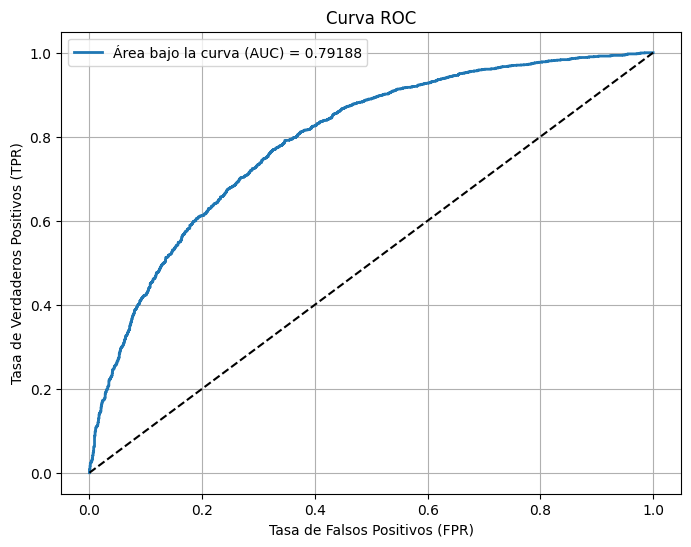

In [ ]:
#Curva ROC
fpr_RBF, tpr_RBF, _ = roc_curve(y_test_encoded, pred_scoresRBF)
roc_auc_RBF = roc_auc_score(y_test_encoded, pred_scoresRBF)

# Usar la función plot_roc_curve
plot_roc_curve(fpr_RBF, tpr_RBF, label=f'Área bajo la curva (AUC) = {roc_auc_RBF:.5f}')

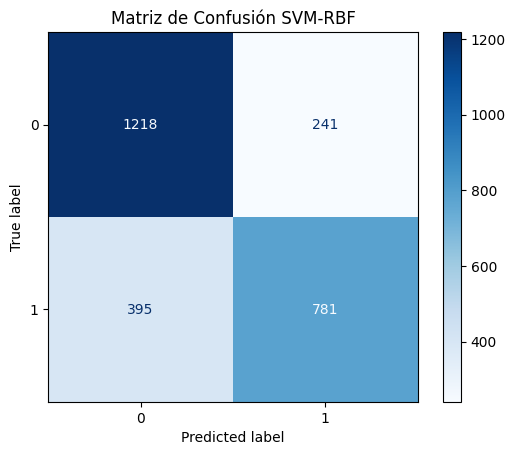

In [ ]:
#Matriz de Confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_RBF = confusion_matrix(y_test_encoded, y_predRBF)
disp_RBF = ConfusionMatrixDisplay(confusion_matrix=cm_RBF)

disp_RBF.plot(cmap='Blues')
plt.title('Matriz de Confusión SVM-RBF')
plt.show()

#Performance Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

P_LR = []
Validation_LR = []
X_LR = np.empty((len(x_train), 1))
for tr_LR, vs_LR in tqdm(kfold.split(X_LR, y_train_encoded), total=5):
  #Conjunto de entrenamiento
  D_tr_LR = [x_train[x] for x in tr_LR]
  Y_tr_LR = [y_train_encoded[x] for x in tr_LR]
  #Conjunto de validación
  D_vs_LR = [x_train[x] for x in vs_LR]
  Y_vs_LR = [y_train_encoded[x] for x in vs_LR]

  #Transformaciones de texto
  tm_LR = TextModel(token_list=[-1, -2, 3]).fit(D_tr_LR)
  X_tr_LR = tm_LR.transform(D_tr_LR)
  X_vs_LR = tm_LR.transform(D_vs_LR)

  #Entrenamos el modelo
  log_reg = LogisticRegression()
  random_search_LR = RandomizedSearchCV(estimator=log_reg, param_distributions=param_grid,n_iter=10, cv=5, scoring='accuracy', verbose=1)
  random_search_LR.fit(X_tr_LR, Y_tr_LR)

  #Entrenamos con los mejores parámetros
  best_LR = random_search_LR.best_estimator_
  hy_LR = best_LR.predict(X_vs_LR)

  #Calculamos el accuracy score
  acc_LR = accuracy_score(Y_vs_LR, hy_LR, normalize=True)
  P_LR.append(acc_LR)

np.mean(P_LR, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 20%|██        | 1/5 [04:16<17:07, 256.91s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 40%|████      | 2/5 [12:08<19:08, 382.97s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 60%|██████    | 3/5 [18:34<12:49, 384.61s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 80%|████████  | 4/5 [25:15<06:31, 391.14s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


100%|██████████| 5/5 [29:43<00:00, 356.67s/it]


0.7418953317349122

In [ ]:
y_predLR = best_LR.predict(tm_LR.transform(x_test))

In [ ]:
#Accuracy Score
acc_LR = accuracy_score(y_test_encoded, y_predLR, normalize=True)
acc_LR

0.7529411764705882

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test_encoded, y_predLR)

0.7341659232827832

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test_encoded, y_predLR)

0.6998299319727891

In [ ]:
from sklearn.model_selection import cross_val_predict
scores_LR = cross_val_predict(best_LR, tm_LR.transform(x_train), y_train_encoded, cv=3,method="decision_function")
pred_scoresLR = best_LR.decision_function(tm_LR.transform(x_test))

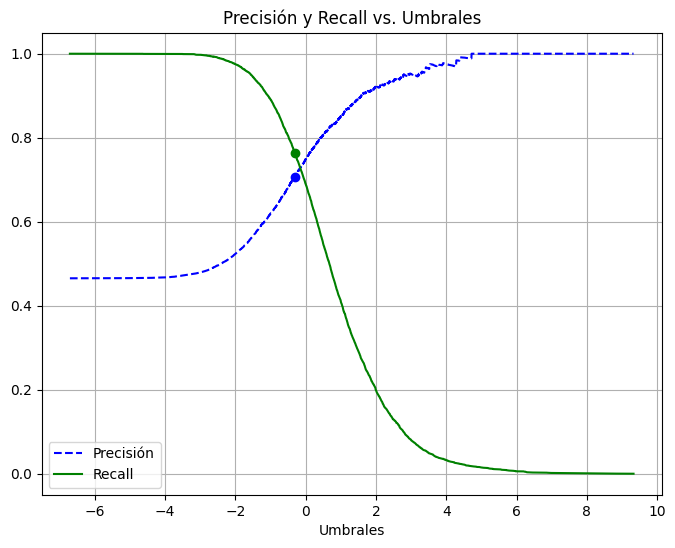

In [ ]:
#Curva precisión y recall vs umbral
precision_LR, recall_LR, thresholds_LR = precision_recall_curve(y_train_encoded, scores_LR)
plot_precision_recall_vs_threshold(precision_LR, recall_LR, thresholds_LR)

In [ ]:
#Umbral para una precisión de 0.75
threshold_90LR = thresholds_LR[np.argmax(precision_LR >= 0.75)]
threshold_90LR

0.0066269884525334

In [ ]:
y_pred_90LR = (pred_scoresLR >= threshold_90LR)
accuracy_score(y_test_encoded, y_pred_90LR, normalize=True)

0.755977229601518

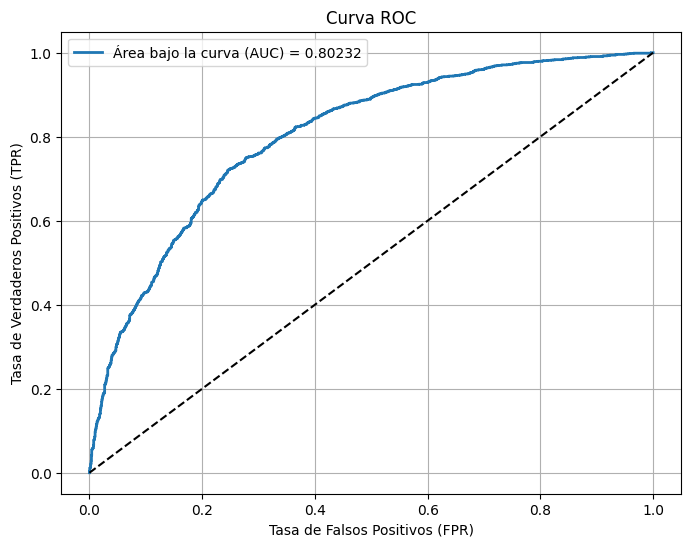

In [ ]:
#Curva ROC
fpr_LR, tpr_LR, _ = roc_curve(y_test_encoded, pred_scoresLR)
roc_auc_LR = roc_auc_score(y_test_encoded, pred_scoresLR)

# Usar la función plot_roc_curve
plot_roc_curve(fpr_LR, tpr_LR, label=f'Área bajo la curva (AUC) = {roc_auc_LR:.5f}')

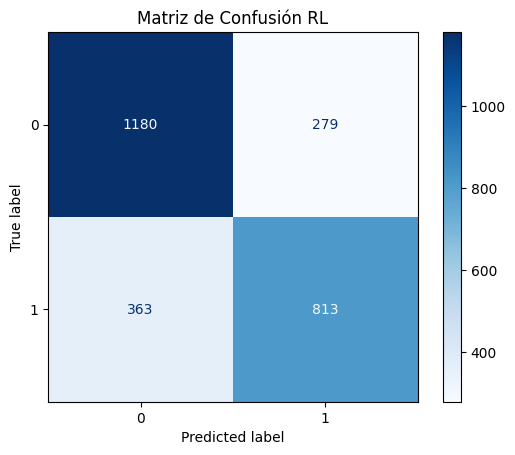

In [ ]:
#Matriz de Confusión
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_LR = confusion_matrix(y_test_encoded, y_predLR)
disp_LR = ConfusionMatrixDisplay(confusion_matrix=cm_LR)

disp_LR.plot(cmap='Blues')
plt.title('Matriz de Confusión RL')
plt.show()

# Performance SaBERT

In [ ]:
!pip install transformers

In [ ]:
!pip install torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install accelerate -U

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Cargar los datos
df = pd.read_csv('/content/BD Aumentada.csv', encoding="latin-1")

# Mapear las etiquetas a valores numéricos
df['klass'] = df['klass'].map({'non-sexist': 0, 'sexist': 1})

# Dividir en conjunto de entrenamiento y prueba
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'].tolist(), df['klass'].tolist(), test_size=0.2, random_state=42)

# Nombre del modelo preentrenado
model_name = "VerificadoProfesional/SaBERT-Spanish-Sentiment-Analysis"

# Cargar el tokenizador y el modelo preentrenado
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenizar los textos
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Crear el Dataset de PyTorch
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Configurar el entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.533300,0.512445
2,0.396200,0.558832


{'eval_loss': 0.5588319301605225, 'eval_runtime': 25.1921, 'eval_samples_per_second': 149.412, 'eval_steps_per_second': 9.368, 'epoch': 2.0}


In [ ]:
import torch

def predict(model, tokenizer, text, threshold=0.5, max_length=128, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenizar el texto y mover los tensores al mismo dispositivo que el modelo
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Realizar la predicción por lotes si es necesario
    num_samples = input_ids.size(0)
    prediction_scores = []

    model.eval()
    with torch.no_grad():
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            input_ids_batch = input_ids[start_idx:end_idx]
            attention_mask_batch = attention_mask[start_idx:end_idx]

            outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)  # Calcula las probabilidades
            prediction_scores_batch = probabilities[:, 1].tolist()  # Extrae las probabilidades de la clase positiva (1)
            prediction_scores.extend(prediction_scores_batch)

    return prediction_scores

In [ ]:
scores_SA = predict(model, tokenizer, train_texts)
pred_scoresSA = predict(model, tokenizer, test_texts)

In [ ]:
from sklearn.metrics import accuracy_score
train_pred = [1 if score >= 0.6 else 0 for score in scores_SA]
accuracy_score(train_labels, train_pred, normalize=True)

0.9223687956723925

In [ ]:
#Accuracy Score
from sklearn.metrics import accuracy_score
true_labels = [1 if score >= 0.6 else 0 for score in pred_scoresSA]
accuracy_score(test_labels, true_labels, normalize=True)

0.796584440227704

In [ ]:
from sklearn.metrics import precision_score
precision_score(test_labels, true_labels)

0.773037542662116

In [ ]:
from sklearn.metrics import recall_score
recall_score(test_labels, true_labels)

0.7704081632653061

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisión")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    # Resaltar un umbral específico (por ejemplo, el umbral medio)
    threshold_highlight = len(thresholds) // 2
    plt.plot(thresholds[threshold_highlight], precisions[threshold_highlight], "bo")
    plt.plot(thresholds[threshold_highlight], recalls[threshold_highlight], "go")

    # Agregar la leyenda, las etiquetas de los ejes y la cuadrícula
    plt.xlabel("Umbrales")
    plt.title("Precisión y Recall vs. Umbrales")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

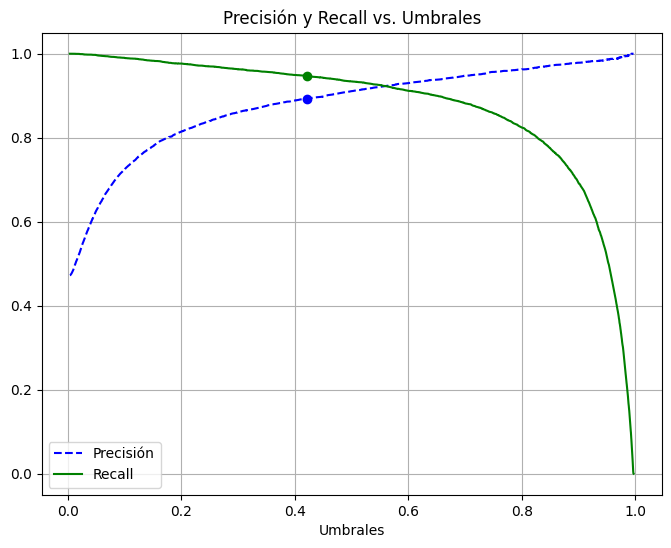

In [ ]:
#Curva Precission-Recall
precision_SA, recall_SA, thresholds_SA = precision_recall_curve(train_labels, scores_SA)
plot_precision_recall_vs_threshold(precision_SA, recall_SA, thresholds_SA)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal punteada

    # Agregar etiquetas de los ejes y la cuadrícula
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

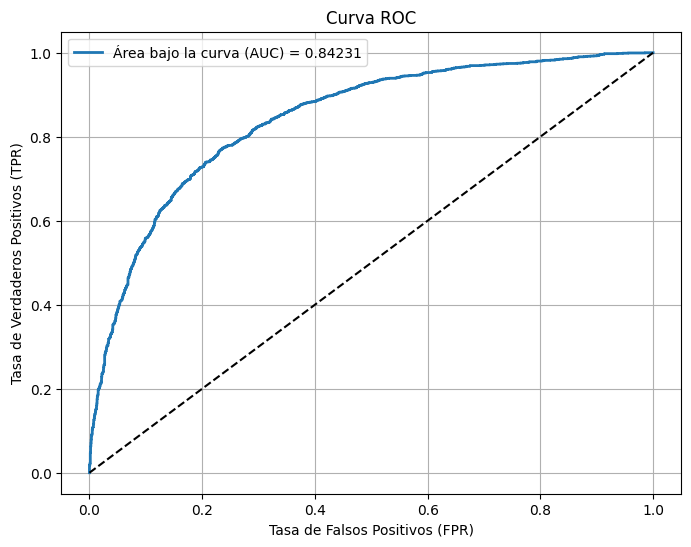

In [ ]:
#Curva ROC
fpr_SA, tpr_SA, _ = roc_curve(test_labels, pred_scoresSA)
roc_auc_SA = roc_auc_score(test_labels, pred_scoresSA)
# Usar la función plot_roc_curve
plot_roc_curve(fpr_SA, tpr_SA, label=f'Área bajo la curva (AUC) = {roc_auc_SA:.5f}')

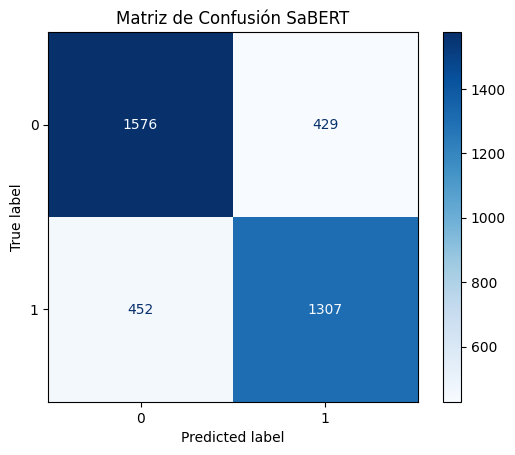

In [ ]:
#Matriz de Confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_bert = confusion_matrix(test_labels, true_labels)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert)

disp_bert.plot(cmap='Blues')
plt.title('Matriz de Confusión SaBERT')
plt.show()

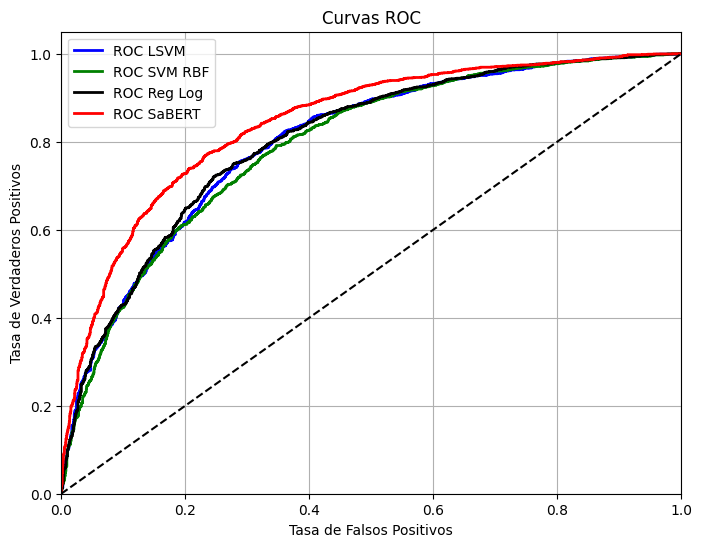

In [ ]:
#Curvas ROC de todos los modelos
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))

plt.plot(fpr_SVC, tpr_SVC, color='blue', lw=2, label=f'ROC LSVM')
plt.plot(fpr_RBF, tpr_RBF, color='green', lw=2, label=f'ROC SVM RBF')
plt.plot(fpr_LR, tpr_LR, color='black', lw=2, label=f'ROC Reg Log')
plt.plot(fpr_SA, tpr_SA, color='red', lw=2, label=f'ROC SaBERT')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc='best')
plt.grid(True)
plt.show()